<a href="https://colab.research.google.com/github/VadPA/PyTorch/blob/master/Lesson_4_hw_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import torch

from torch import nn
from torch.nn import functional as F
from PIL import Image
from torchvision import transforms, datasets
from tqdm import tqdm

from sklearn.model_selection import train_test_split
import pickle
import os

In [2]:
import matplotlib.pyplot as plt
from torchsummary import summary

In [3]:
def load_labels_name(filename):
    with open(filename, 'rb') as f:
        obj = pickle.load(f)
    return obj

In [4]:
def train_valid_split(Xt):
    X_train, X_test = train_test_split(Xt, test_size=0.05, random_state=13)
    return X_train, X_test

In [5]:
class MyOwnCifar(torch.utils.data.Dataset):
   
    def __init__(self, init_dataset, transform=None):
        self._base_dataset = init_dataset
        self.transform = transform

    def __len__(self):
        return len(self._base_dataset)

    def __getitem__(self, idx):
        img = self._base_dataset[idx][0]
        if self.transform is not None:
            img = self.transform(img)
        return img, self._base_dataset[idx][1]

In [6]:
dataset = datasets.CIFAR100(root='data/', train=True, download=True)

  0%|          | 0/169001437 [00:00<?, ?it/s]

Extracting data/cifar-100-python.tar.gz to data/


In [7]:
trans_actions = transforms.Compose([transforms.Resize(44),
                                    transforms.RandomCrop(32, padding=4), 
                                    transforms.ToTensor()])

In [8]:
train_dataset, valid_dataset = train_valid_split(dataset)

In [9]:
train_dataset = MyOwnCifar(train_dataset, trans_actions)
valid_dataset = MyOwnCifar(valid_dataset, transforms.ToTensor())

In [10]:
train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size=128,
                                           shuffle=True,
                                           num_workers=2)
valid_loader = torch.utils.data.DataLoader(valid_dataset,
                                           batch_size=128,
                                           shuffle=False,
                                           num_workers=1)

In [11]:
files = os.listdir('data/cifar-100-python')
print(files)

['meta', 'file.txt~', 'train', 'test']


In [12]:
data_cifar100 = load_labels_name('data/cifar-100-python/meta')

In [13]:
classes_cifar100 = data_cifar100['fine_label_names']

torch.Size([128, 3, 32, 32])
man


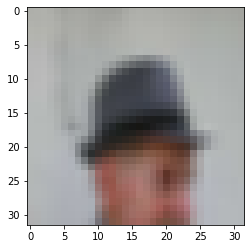

In [14]:
for img, lbl in train_loader:
    print(img.shape)
    print(classes_cifar100[lbl[0]])
    plt.imshow(img[0].permute(1, 2, 0))
    break

In [15]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [16]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.dp_one = nn.Dropout(0.2)
        self.dp_two = nn.Dropout(0.2)
        
        self.bn_one = torch.nn.BatchNorm2d(3) 
        self.conv_one = torch.nn.Conv2d(3, 30, 3)
        self.bn_two = torch.nn.BatchNorm2d(30) 
        self.conv_two = torch.nn.Conv2d(30, 60, 3)
        self.bn_three = torch.nn.BatchNorm2d(60)
        self.conv_three = torch.nn.Conv2d(60, 120, 3)
        self.bn_four = torch.nn.BatchNorm2d(120)
        self.fc1 = torch.nn.Linear(480, 200)
        self.fc2 = torch.nn.Linear(200, 160)
        self.out = torch.nn.Linear(160, 100)
        
    def forward(self, x):
        x = self.bn_one(x)
        x = self.conv_one(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        
        x = self.bn_two(x)
        x = self.conv_two(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        
        x = self.bn_three(x)
        x = self.conv_three(x)
        x = F.leaky_relu(x, 0.1)
        x = F.max_pool2d(x, 2)
        
        x = self.bn_four(x)
        x = x.view(x.size(0), -1)
        x = self.dp_one(x)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dp_two(x)
        x = self.fc2(x)
        x = F.relu(x)
        return self.out(x)

In [17]:
net = Net()
print(net)

Net(
  (dp_one): Dropout(p=0.2, inplace=False)
  (dp_two): Dropout(p=0.2, inplace=False)
  (bn_one): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_one): Conv2d(3, 30, kernel_size=(3, 3), stride=(1, 1))
  (bn_two): BatchNorm2d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_two): Conv2d(30, 60, kernel_size=(3, 3), stride=(1, 1))
  (bn_three): BatchNorm2d(60, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_three): Conv2d(60, 120, kernel_size=(3, 3), stride=(1, 1))
  (bn_four): BatchNorm2d(120, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=480, out_features=200, bias=True)
  (fc2): Linear(in_features=200, out_features=160, bias=True)
  (out): Linear(in_features=160, out_features=100, bias=True)
)


In [18]:
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

In [19]:
summary(net.to(device), input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
       BatchNorm2d-1            [-1, 3, 32, 32]               6
            Conv2d-2           [-1, 30, 30, 30]             840
       BatchNorm2d-3           [-1, 30, 15, 15]              60
            Conv2d-4           [-1, 60, 13, 13]          16,260
       BatchNorm2d-5             [-1, 60, 6, 6]             120
            Conv2d-6            [-1, 120, 4, 4]          64,920
       BatchNorm2d-7            [-1, 120, 2, 2]             240
           Dropout-8                  [-1, 480]               0
            Linear-9                  [-1, 200]          96,200
          Dropout-10                  [-1, 200]               0
           Linear-11                  [-1, 160]          32,160
           Linear-12                  [-1, 100]          16,100
Total params: 226,906
Trainable params: 226,906
Non-trainable params: 0
-------------------------------

In [22]:
num_epochs = 25
net.train()

Net(
  (dp_one): Dropout(p=0.2, inplace=False)
  (dp_two): Dropout(p=0.2, inplace=False)
  (bn_one): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_one): Conv2d(3, 30, kernel_size=(3, 3), stride=(1, 1))
  (bn_two): BatchNorm2d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_two): Conv2d(30, 60, kernel_size=(3, 3), stride=(1, 1))
  (bn_three): BatchNorm2d(60, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_three): Conv2d(60, 120, kernel_size=(3, 3), stride=(1, 1))
  (bn_four): BatchNorm2d(120, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=480, out_features=200, bias=True)
  (fc2): Linear(in_features=200, out_features=160, bias=True)
  (out): Linear(in_features=160, out_features=100, bias=True)
)

In [24]:
for epoch in range(num_epochs):  
    running_loss, running_items, running_right = 0.0, 0.0, 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)

        # обнуляем градиент
        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # выводим статистику о процессе обучения
        running_loss += loss.item()
        running_items += len(labels)
        running_right += (labels  == torch.max(outputs, 1)[1]).sum()
        
        # выводим статистику о процессе обучения
        if i % 300 == 0:    # печатаем каждые 300 mini-batches
            net.eval()
            
            print(f'Epoch [{epoch + 1}/{num_epochs}]. ' \
                  f'Step [{i + 1}/{len(train_loader)}]. ' \
                  f'Loss: {running_loss / running_items:.3f}. ' \
                  f'Acc: {running_right / running_items:.3f}', end='. ')
            running_loss, running_items, running_right = 0.0, 0.0, 0.0

            test_running_right, test_running_total = 0.0, 0.0
            for i, data in enumerate(valid_loader, 0):
            
                test_outputs = net(data[0].to(device))
                test_running_total += len(data[1])
                test_running_right += (data[1].to(device) == torch.max(test_outputs, 1)[1]).sum()
            
            print(f'Test acc: {test_running_right / test_running_total:.3f}')
        
        net.train()
        
print('Training is finished!')

Epoch [1/25]. Step [1/372]. Loss: 0.019. Acc: 0.289. Test acc: 0.240
Epoch [1/25]. Step [301/372]. Loss: 0.020. Acc: 0.341. Test acc: 0.264
Epoch [2/25]. Step [1/372]. Loss: 0.016. Acc: 0.383. Test acc: 0.275
Epoch [2/25]. Step [301/372]. Loss: 0.020. Acc: 0.343. Test acc: 0.276
Epoch [3/25]. Step [1/372]. Loss: 0.021. Acc: 0.297. Test acc: 0.244
Epoch [3/25]. Step [301/372]. Loss: 0.020. Acc: 0.339. Test acc: 0.275
Epoch [4/25]. Step [1/372]. Loss: 0.021. Acc: 0.383. Test acc: 0.276
Epoch [4/25]. Step [301/372]. Loss: 0.020. Acc: 0.345. Test acc: 0.275
Epoch [5/25]. Step [1/372]. Loss: 0.019. Acc: 0.383. Test acc: 0.272
Epoch [5/25]. Step [301/372]. Loss: 0.020. Acc: 0.344. Test acc: 0.284
Epoch [6/25]. Step [1/372]. Loss: 0.018. Acc: 0.414. Test acc: 0.286
Epoch [6/25]. Step [301/372]. Loss: 0.020. Acc: 0.349. Test acc: 0.265
Epoch [7/25]. Step [1/372]. Loss: 0.022. Acc: 0.297. Test acc: 0.271
Epoch [7/25]. Step [301/372]. Loss: 0.020. Acc: 0.351. Test acc: 0.288
Epoch [8/25]. Step [

In [58]:
valid_loader = torch.utils.data.DataLoader(valid_dataset,
                                           batch_size=8,
                                           shuffle=True,
                                           num_workers=1)

In [59]:
data_iter = iter(valid_loader)
inputs, labels = data_iter.next()
labels = labels.to(device)
inputs = inputs.to(device)
labels

tensor([84, 22, 53, 30, 98, 49, 68, 59], device='cuda:0')

In [31]:
import torchvision

GroundTruth:  table clock orange dolphin woman mountain road pine_tree


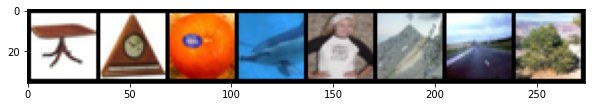

In [60]:
net.eval()
outputs = net(inputs)
imgs = torchvision.utils.make_grid(inputs.to('cpu'))
plt.figure(figsize=(10, 5))
plt.imshow(imgs.permute(1, 2, 0).numpy())
print('GroundTruth: ', ' '.join(classes_cifar100[labels[j]] for j in range(len(labels))))

In [61]:
print(outputs)

tensor([[-5.8007e+00, -1.0321e+01, -5.1708e+00, -1.1348e+01, -9.1463e+00,
          1.1263e+00, -6.7253e+00, -2.6862e+00, -5.0324e+00, -4.4531e+00,
         -8.5426e-01, -1.8505e+00, -5.8314e+00, -7.4330e+00, -4.0379e+00,
         -7.8680e-01, -1.2735e+00, -1.4197e+01, -8.4202e+00, -7.4332e+00,
          6.9738e+00, -1.1446e+01, -1.4140e-01, -1.6952e+01, -2.3808e-01,
         -1.2381e+00, -1.8229e+00, -1.1557e+01,  9.3040e-01,  9.6352e-01,
         -1.5582e+01, -9.0109e+00, -8.3542e+00, -1.5100e+01, -4.4694e+00,
         -5.1802e+00, -8.3876e+00, -8.5583e+00, -4.8107e+00, -3.6975e+00,
          2.0354e+00, -1.4174e+00, -7.1914e+00, -1.4355e+01, -9.0713e-01,
         -9.9420e-01, -5.7047e+00, -1.1926e+01, -3.8158e+00, -1.1817e+01,
         -3.5677e+00, -4.3658e+00, -2.2260e+01, -6.7821e+00, -1.4156e+00,
         -4.2903e+00, -8.4874e+00, -3.6516e+00, -4.1903e+00, -1.0133e+01,
         -1.1579e+01, -1.9695e+00, -7.5410e+00, -1.1213e+01, -9.1138e+00,
         -5.4332e+00, -7.7492e+00, -8.

In [62]:
_, predicted = torch.max(outputs, 1)

predicted

tensor([20, 48, 53, 95, 26, 49, 95, 52], device='cuda:0')

In [63]:
print('Predicted: ', ' '.join(classes_cifar100[predicted[j]] for j in range(len(labels))))

Predicted:  chair motorcycle orange whale crab mountain whale oak_tree


In [64]:
gt = np.array([classes_cifar100[labels[j]] for j in range(len(labels))])
pred = np.array([classes_cifar100[predicted[j]] for j in range(len(labels))])

print(gt)
print(pred)
print(f'Accuracy is {(gt == pred).sum() / len(gt):.4f}')

['table' 'clock' 'orange' 'dolphin' 'woman' 'mountain' 'road' 'pine_tree']
['chair' 'motorcycle' 'orange' 'whale' 'crab' 'mountain' 'whale'
 'oak_tree']
Accuracy is 0.2500
